In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# append source
import os,sys
ck_g_cnn_source =  os.path.join(os.getcwd(),'..')
if ck_g_cnn_source not in sys.path:
    sys.path.append(ck_g_cnn_source)

from ck_g_cnn.groups import SE2

from ck_g_cnn.nn.conv import GroupConv
from ck_g_cnn.nn.conv import GroupConvSeparable
from ck_g_cnn.nn.conv import GroupConvBlock
from ck_g_cnn.nn.conv import LiftingConv

from demo.utils import (
    visualize_lifting_coordinate_grids,
    visualize_group_coordinate_grids,
    visualize_lifting_kernels,
    visualize_group_kernels
)

# 0. Configuration

This section contains parameters used throughout the notebook. These can be changed to inspect their impact on the resulting convolution kernels.

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]

kernel_size = 7
in_channels = 1
out_channels = 2
out_channels_group = 2
ck_net_num_hidden = 2
ck_net_hidden_size = 32
ck_net_implementation = "SIREN"
ck_net_first_omega_0=1
ck_net_omega_0=10
sampling_method="uniform"
stride=1
padding=True

# group is set to include 8 elements
num_elements = 8
group_elements = torch.linspace(0, 360 * float(num_elements - 1) / float(num_elements), num_elements)

group = SE2()
# group = Rplus()

# 1. Visualising the kernel coordinate grids

In this section, the kernel coordinate grids for lifting and group convolutions are visualised. This is done to show the group action working on the kernel coordinate grid.

## 1.1 Visualising lifting coordinate grids

First, the coordinate grids used to sample the lifting convolution kernels are visualised. These kernels have 2 dimensions, the two spatial dimensions over which an input image is defined.

In [4]:
lifting_conv = LiftingConv(
    group=group,
    kernel_size=kernel_size,
    num_group_elem=num_elements,
    in_channels=in_channels,
    out_channels=out_channels,
    ck_net_num_hidden=ck_net_num_hidden,
    ck_net_hidden_size=ck_net_hidden_size,
    ck_net_implementation=ck_net_implementation,
    ck_net_first_omega_0=ck_net_first_omega_0,
    ck_net_omega_0=ck_net_omega_0,
    sampling_method=sampling_method,
    stride=stride,
    padding=padding
)


/Users/davidknigge/opt/anaconda3/envs/sepgcnns/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


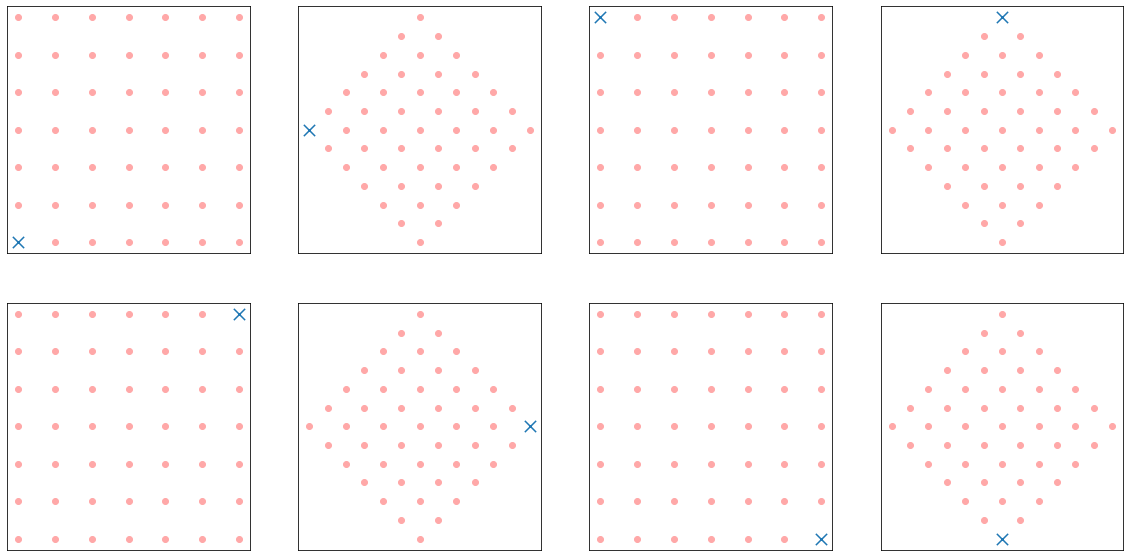

In [5]:
# sample group elements to apply to filters, note the sampling method
sampled_group_elements = lifting_conv.kernel.group.sample(
    num_elements=lifting_conv.num_group_elem,
    method="discretise"
)

# Define a kernel grid on R2
grid_R2 = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, kernel_size, dtype=torch.float),
    torch.linspace(-1, 1, kernel_size, dtype=torch.float),
))

# transform kernel grids by all group elements
kernel_grids = lifting_conv.kernel.transform_grid_by_group(grid_R2, sampled_group_elements)

visualize_lifting_coordinate_grids(kernel_grids)

## 1.2 Visualising group coordinate grids

Next, we visualise the kernel grids under transformations for group convolutions. We visualise grids for three implementations:

1. Continuous: Here a kernel grid extends over the entire group in the input dimension, as well as a $\texttt{kernel_size} \times \texttt{kernel_size}$ patch of the spatial dimensions. This kernel grid is then transformed for every element of the group.
2. Continuous-separable: Here the group convolution is implemented as separated over the group and spatial dimensions. First, a convolution over the input group dimension of size $1 \times \texttt{num_group_elements}$ is performed for every sampled group element. Afterwards, each obtained feature map / output channel is convolved over in the spatial dimension.

### 1.2.2 Continuous group coordinate grids

In [6]:

gconv_cont = GroupConv(
    group=group,
    kernel_size=kernel_size,
    num_group_elem=num_elements,
    in_channels=in_channels,
    out_channels=out_channels,
    ck_net_num_hidden=ck_net_num_hidden,
    ck_net_hidden_size=ck_net_hidden_size,
    ck_net_implementation=ck_net_implementation,
    ck_net_first_omega_0=ck_net_first_omega_0,
    ck_net_omega_0=ck_net_omega_0,
    sampling_method=sampling_method,
    stride=stride,
    padding=padding
)

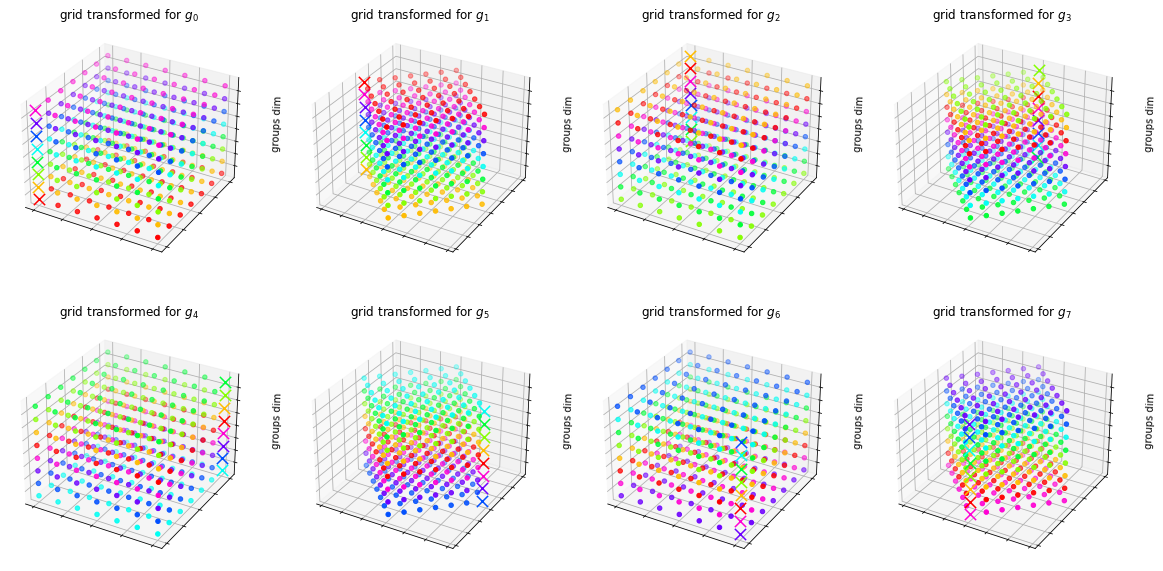

In [7]:
# again, in the continuous case, we sample group elements in every forward pass. Therefore, we also sample
# the kernels themselves every forward pass. Note that we also need to specify the group elements for which we have
# feature maps in the input dimension. We can obtain the kernel grids by:

# let us assume we have the following group elements in our input dimension. Normally, these are
# provided in a call to GroupConvContinuous.forward
grid_H = gconv_cont.kernel.group.sample(num_elements=gconv_cont.num_group_elem, method="uniform")

# sample group elements to apply to filters
sampled_group_elements = gconv_cont.kernel.group.sample(num_elements=gconv_cont.num_group_elem, method="discretise")

# transform kernel grids by all group elements
grids = gconv_cont.kernel.transform_grid_by_group(grid_R2, grid_H, sampled_group_elements)

visualize_group_coordinate_grids(grids)

### 1.2.3 Continuous separable group coordinate grids

In [8]:
gconv_sep = GroupConvSeparable(
    group=group,
    kernel_size=kernel_size,
    num_group_elem=num_elements,
    in_channels=in_channels,
    out_channels=out_channels,
    ck_net_num_hidden=ck_net_num_hidden,
    ck_net_hidden_size=ck_net_hidden_size,
    ck_net_implementation=ck_net_implementation,
    ck_net_first_omega_0=ck_net_first_omega_0,
    ck_net_omega_0=ck_net_omega_0,
    stride=stride,
    padding=padding,
    sampling_method=sampling_method
)

In [9]:
# 

# 2. Visualising the convolution kernels

Next, we visualise the kernels themselves under transformations for group convolutions. We visualise kernels for three implementations:

1. Discrete: Here a kernel grid extends over the entire group in the input dimension, as well as a $\texttt{kernel_size} \times \texttt{kernel_size}$ patch of the spatial dimensions. This kernel grid is then transformed for every element of the group.
2. Continuous: Same as for 1.
3. Continuous-separable: Here the group convolution is implemented as separated over the group and spatial dimensions. First, a convolution over the input group dimension of size $1 \times \texttt{num_group_elements}$ is performed for every sampled group element. Afterwards, each obtained feature map / output channel is convolved over in the spatial dimension.

## 2.1 Visualising lifting convolution kernels

### 2.1.1 Lifting convolution kernels

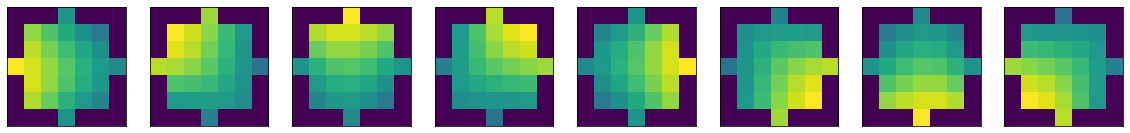

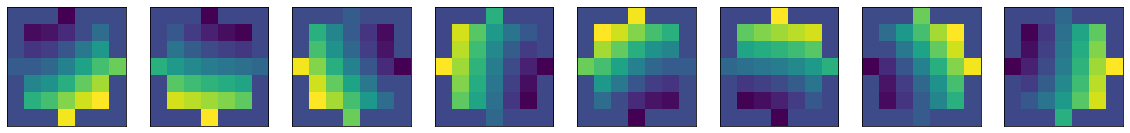

In [10]:
# in the discrete case, again, we can immediately sample our kernels with the transformed grids
conv_kernels = lifting_conv.kernel.sample(sampled_group_elements)

visualize_lifting_kernels(conv_kernels.transpose(0, 1).detach().numpy())

## 2.2 Visualising group convolution kernels

### 2.2.1 Full group convolution kernels

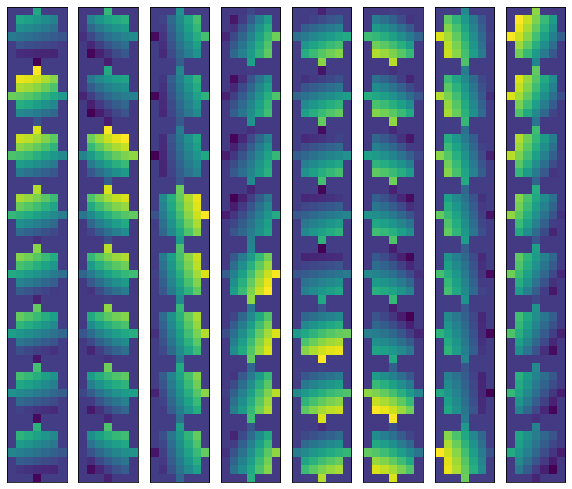

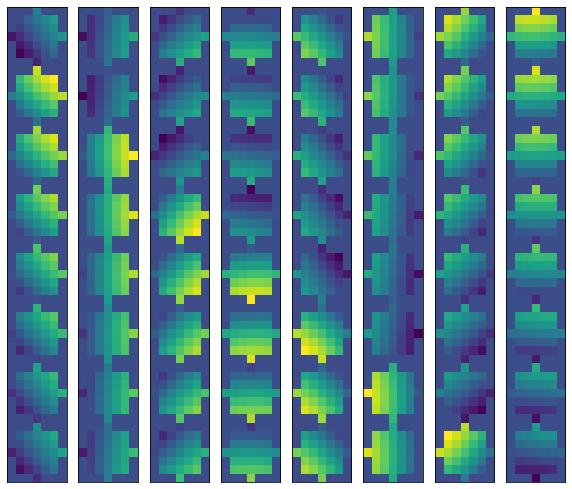

In [11]:
conv_kernels = gconv_cont.kernel.sample(sampled_group_elements, grid_H)

# different input group elements are stacked vertically
visualize_group_kernels(conv_kernels.detach().numpy())

### 2.2.2 Separable group convolutions

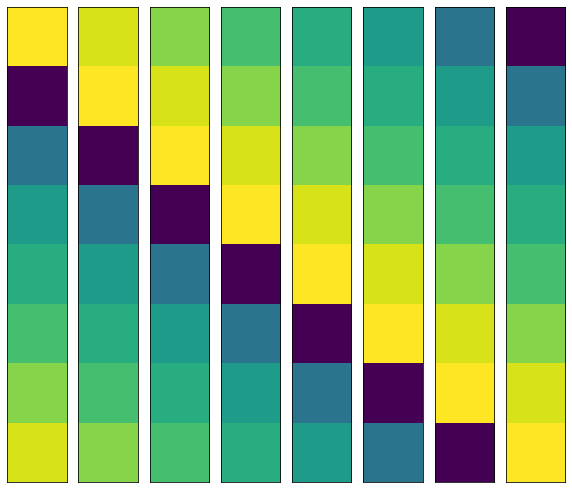

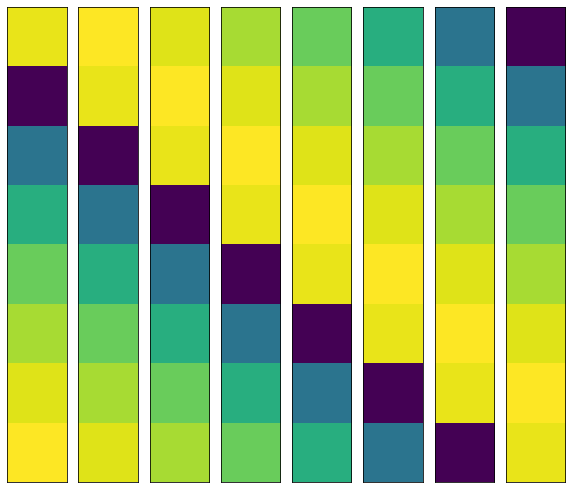

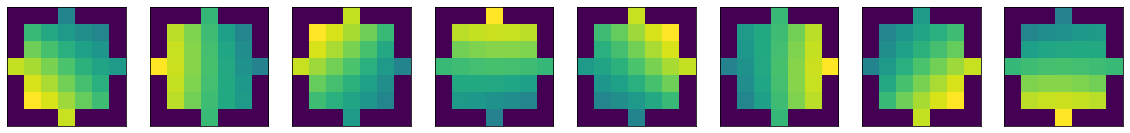

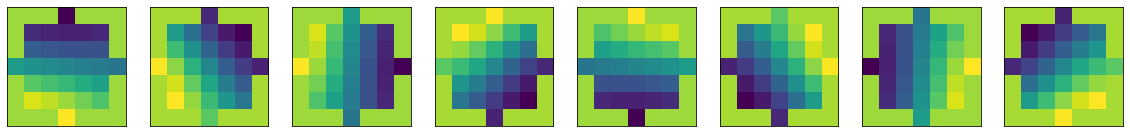

In [12]:
kernels_H, kernels_R2 = gconv_sep.kernel.sample(sampled_group_elements, grid_H)

# different input group elements are stacked vertically
visualize_group_kernels(kernels_H.detach().numpy())

visualize_lifting_kernels(kernels_R2.transpose(0, 1).detach().numpy())